<a href="https://colab.research.google.com/github/GwiHwan-Go/Detect_SC/blob/main/Depression_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Detect_SC_symptoms'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Detect_SC_symptoms


In [ ]:
# !pip install konlpy
!pip install soynlp
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 게시글에서 우울증 지수를 뽑아내보자.

1. PMI 분석된 것을 기준. [PMI란?](!https://github.com/lovit/soynlp/blob/master/tutorials/pmi_usage.ipynb)
2. Seeds 단어들(자살과 관련된 핵심적인 단어들)로 시작
3. 관련 단어 상위 10위, 가까운 것부터 배수 배정
4. gradient를 곱해서 다시 PMI 분석. -> 정해진 기준까지.
5. 다 더한다.

## Params 화 해서 heuristic 하게 조정해보자.

In [ ]:
from scipy import sparse
import pickle
from soynlp.word import pmi as pmi_func
from sklearn.metrics import pairwise_distances
import numpy as np

class Pmi() :

  def __init__(self, words_mat_path, index_list_path) :

    self.mat = sparse.load_npz(mat_save_path)

    with open(index_list_save_path, "rb") as fp:   # Unpickling
      self.idx2vocab = pickle.load(fp)

    self.pmi, self.px, self.py = pmi_func(
                                  self.mat,
                                  min_pmi = 0,
                                  alpha = 0.0,
                                  beta = 0.75
                              )
    self.vocab2idx = {vocab:idx for idx, vocab in enumerate(self.idx2vocab)}

  def np_context_words(self ,target, topk=10) :

    # query = self.vocab2idx[target]

    submatrix = self.pmi[target, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    results = np.array(most_relateds)
    # most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return results

  def context_words(self ,target, topk=10) :

    query = self.vocab2idx[target]

    submatrix = self.pmi[query, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    # results = np.array(most_relateds)
    most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return most_relateds
  def similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :self.pmi: numpy.ndarray or scipy.sparse.matrix
          self.pmi representation of row
      :self.vocab2idx: dict
          Mapper from str type item to int type index
      :self.idx2vocab: list
          Mapper from int type index to str type item
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      q = self.vocab2idx.get(target, -1)
      if q == -1:
          return []

      qvec = self.pmi[target].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      # results = np.array(results)
      results = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in results]

      return results
   
  def np_similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :self.pmi: numpy.ndarray or scipy.sparse.matrix
          self.pmi representation of row
      :self.vocab2idx: dict
          Mapper from str type item to int type index
      :self.idx2vocab: list
          Mapper from int type index to str type item
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      # q = self.vocab2idx.get(target, -1)
      # if q == -1:
      #     return []

      qvec = self.pmi[target].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != target]
      results = np.array(results)

      return results
  
  def idx_to_word(self, indices_list) :
    
    return [self.idx2vocab[index] for index in indices_list]

  def word_to_idx(self, word_list) :

    return [self.vocab2idx[word] for word in word_list]



mat_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/words_sparse_mat.npz"
index_list_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/idx_to_vocabs"
pmi = Pmi(mat_save_path,index_list_save_path)

In [ ]:
np.where(context_words[:,0])

array([0.18399721, 0.18317524, 0.17020227, 0.16308425, 0.15725072,
       0.15645059, 0.15544148, 0.14975371, 0.14689529, 0.14523871])

In [ ]:
from tqdm import tqdm

In [ ]:
from scipy import sparse

# network = np.zeros((len(pmi.idx2vocab),len(pmi.idx2vocab)))

def make_network_array(node,current_recursion=0,graph_boundary=5,max_recursion=10,alpha=0.7) :

  global network

  context_words = pmi.np_context_words(node,topk=30) #context 뽑아오기
  context_words = context_words[np.where(context_words[:,1] > graph_boundary),:][0]

  if context_words.shape[0] == 0 :
    return []

  indices = np.array(context_words[:,0], dtype='int32')
  alpha = alpha**current_recursion

  network[int(node),indices]=context_words[:,1]*alpha
  # print(int(node), "-->", indices)
  if current_recursion <= max_recursion :
    for id in context_words[:,0] :
      make_network_array(id,
                        current_recursion=current_recursion+1,
                        graph_boundary=graph_boundary,
                        max_recursion=max_recursion)
  else :
    return []

seeds = ['자살','동반',
        '죽을래','투신','자해','죽고싶다','우울','살자',
        '인생','죽음']
graph_boundary = 3.5
max_recursion = 2

for seed in tqdm(pmi.word_to_idx(seeds)) :
    print(seed)
    make_network_array(int(seed),
                  current_recursion=0,
                  graph_boundary=graph_boundary,
                  max_recursion=max_recursion)


from scipy.sparse import csr_matrix
network_path='./models/simple_context_graph.npz'
csr_network = csr_matrix(network)
sparse.save_npz(network_path,csr_network)

  0%|          | 0/10 [00:00<?, ?it/s]

4604


 10%|█         | 1/10 [10:36<1:35:25, 636.20s/it]

13279


 20%|██        | 2/10 [18:46<1:13:21, 550.24s/it]

19674


 30%|███       | 3/10 [25:42<57:04, 489.16s/it]  

22896


 40%|████      | 4/10 [33:26<47:55, 479.32s/it]

4858


 50%|█████     | 5/10 [43:10<43:04, 516.84s/it]

9804


 60%|██████    | 6/10 [51:05<33:30, 502.63s/it]

267


 70%|███████   | 7/10 [59:46<25:26, 508.71s/it]

2636


 80%|████████  | 8/10 [1:08:59<17:25, 522.88s/it]

84


 90%|█████████ | 9/10 [1:15:54<08:09, 489.12s/it]

1584


100%|██████████| 10/10 [1:25:46<00:00, 514.70s/it]


In [ ]:
network_path='./models/similar_graph_final.npz'
sparse.save_npz(network_path,csr_network)

In [ ]:
import networkx as nx

sparse_matrix = scipy.sparse.load_npz(network_path)
G=nx.from_scipy_sparse_matrix(csr_network)

NameError: ignored

In [ ]:
G.nodes

In [ ]:
seeds = ['자살', '자해', '동반', '우울', '죽음']
graph_boundary = 3
max_recursion = 15
ids = pmi.word_to_idx(seeds)
CG2 = nx.DiGraph()

for seed in tqdm(pmi.word_to_idx(seeds)) :
  CG2.add_node(seed)
  plot_graph(seed,
            current_recursion=0,
            graph_boundary=graph_boundary,
            max_recursion=max_recursion)

graph_name = './results/PMI_words_graph2.pickle'
# save graph object to file
pickle.dump(CG2, open(graph_name, 'wb'))

In [ ]:
CG = pickle.load(open(graph_name, 'rb'))

In [ ]:
# pos = nx.spring_layout(CG) 
# labels =nx.get_edge_attributes(CG,'weight')
# nx.draw_networkx_edge_labels(CG, pos, edge_labels = labels) 
nx.draw(CG, pos,with_labels = True, font_weight = "bold") 

In [ ]:
from matplotlib import pylab
import networkx as nx

 def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(g,"my_graph.pdf")

In [ ]:
def preprocess(text) :
  """
  exclude alphabet, lower the alphabets
  input : nltk.text.Text ??
  output : 
  """
  from nltk.corpus import stopwords
  text = [w.lower() for w in text 
          if (len(w)>1) and 
              (w.isalpha()) and 
              (w not in stopwords.words('english'))]
  return text

def get_diversity(text) :
  """
  Look at diversity of using word in the text
  the higher the more diverse, which means vocabulary ability is higher.
  input : nltk.text.Text
  output : integer (the lower the more diverse)
  """
  text = preprocess(text)
  print(type(text))
  return len(set(text)) / len(text)

def count(word, text, exclude_duplicate=True) :
  """
  Look at the percentage of the word in the text
  input : nltk.text.Text
  output : integer (the lower the more diverse)
  """
  text = preprocess(text)

  if exclude_duplicate :
    text = set(text)
  return round(FreqDist(text)['word'] / len(text), 5)*100

def save_df(df,name) :

  path = './results' +'/' + name
  df.to_csv(path)
  print(f"저장성공 경로 : {path} ")

In [ ]:
# 결과물 저장 경로
save_dir = "/content/drive/MyDrive/Detect_SC_symptoms/results"
file_name = "refined_full_custom_tokenizer.csv" # tokenized X = refined_full.csv / with Okt tokenizer = refined_full_okt_tokenized.csv
data_path = f"/content/drive/MyDrive/Detect_SC_symptoms/results/{file_name}" 
data = pd.read_csv(data_path, low_memory=False, index_col=0) 
first_id, last_id = data.loc[0,'id'], data.loc[data.shape[0]-1,'id']
first_day, last_day = data.loc[0,'date'], data.loc[data.shape[0]-1,'date']
print("총 기간", first_day, '~', last_day )
print("수집한 게시물 범위 :", first_id, "~", last_id, "\n" \
      "수집된 데이터 크기 :", data.shape[0], "\n수집한 데이터 features :", data.columns)
data.tail()

총 기간 2021-03-03 ~ 2022-10-27
수집한 게시물 범위 : 2 ~ 4445728 
수집된 데이터 크기 : 2470236 
수집한 데이터 features : Index(['id', 'title', 'author', 'date', 'link'], dtype='object')


,id,title,author,date,link
2470231,4445724,나 병신 ...,민애,2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470232,4445725,나고 닉 글 올리 규 싶 읃데,조팡이(118.235),2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470233,4445726,씨발 남자 직원 음식 깔아 주,연우ㅗ(223.62),2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470234,4445727,나도 근데 아이디 두 번 바꿈,.O2,2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470235,4445728,알바 바보 쉨 ㅋㅋㅋ 나도 차단 해봐라,민애,2022-10-27,https://m.dcinside.com/board/depression_new1/4...


In [ ]:
print(f"중복, NAN 제거 전 데이터 수 = {data.shape}")
data = data.drop_duplicates(['id'])
data = data[data.title.isna()==False]
print(f"중복, NAN 제거 후 데이터 수 = {data.shape}")

중복, NAN 제거 전 데이터 수 = (2470236, 5)
중복, NAN 제거 후 데이터 수 = (2469803, 5)


## 텍스트 데이터는 어떤 정보를 가지고 있을까?

In [ ]:
# 학습시킨 Tokenizer 불러 오기
import math
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

model_fname="/content/drive/MyDrive/Detect_SC_symptoms/models" + "/" + "soy_wordExtractor_full.model"

## Word_Extractor param 설정 및 로드
word_extractor = WordExtractor(min_frequency=10,
                               min_cohesion_forward=5.0,
                               min_right_branching_entropy=0.0)
word_extractor.load(model_fname)

## Cohesion 과 Entropy 계산해서 tokenizer 생성
scores = word_extractor.word_scores()
scores = {key : (scores[key].cohesion_forward * math.exp(scores[key].right_branching_entropy)) \
          for key in scores.keys()}

## tokenizer 생성
tokenizer = LTokenizer(scores=scores)

all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


In [ ]:
from konlpy.tag import Okt

## 완성된 우리의 TOKENIZER##

def preprocess_tokenizer(sentence) : 

  pos_tagger = Okt()
  # sentence = emoticon_normalize(sentence) 자세한 건 soyNLP 공식문서 참고 https://github.com/lovit/soynlp
  # sentence = repeat_normalize(sentence) 자세한 건 soyNLP 공식문서 참고 https://github.com/lovit/soynlp

  #soynlp tokenizer로 나눠준 후 konlpy Okt postagger로 품사 판별
  return [word[0]
          for word in pos_tagger.pos(' '.join(tokenizer.tokenize(sentence)))
          if word[1] != 'Josa'] # 조사는 분석에서 제외

In [ ]:
from scipy import sparse
import pickle
from soynlp.word import pmi as pmi_func
from sklearn.metrics import pairwise_distances
import numpy as np

class Pmi() :

  def __init__(self, words_mat_path, index_list_path) :

    self.mat = sparse.load_npz(mat_save_path)

    with open(index_list_save_path, "rb") as fp:   # Unpickling
      self.idx2vocab = pickle.load(fp)

    self.pmi, self.px, self.py = pmi_func(
                                  self.mat,
                                  min_pmi = 0,
                                  alpha = 0.0,
                                  beta = 0.75
                              )
    self.vocab2idx = {vocab:idx for idx, vocab in enumerate(self.idx2vocab)}

  def context_words(self ,target, topk=10) :

    # query = self.vocab2idx[target]

    submatrix = self.pmi[target, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    results = np.array(most_relateds)
    # most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return results

  def similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :self.pmi: numpy.ndarray or scipy.sparse.matrix
          self.pmi representation of row
      :self.vocab2idx: dict
          Mapper from str type item to int type index
      :self.idx2vocab: list
          Mapper from int type index to str type item
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      # q = self.vocab2idx.get(target, -1)
      # if q == -1:
      #     return []

      qvec = self.pmi[target].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      results = np.array(results)

      return results
  
  def results_to_word(self, result_list) :

    return [(self.idx2vocab[int(idx)], pmi_ij) for idx, pmi_ij in result_list]
  
  def idx_to_word(self, indices_list) :
    
    return [self.idx2vocab[word] for index in indices_list]

  def word_to_idx(self, word_list) :

    return [self.vocab2idx[word] for word in word_list]



mat_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/words_sparse_mat.npz"
index_list_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/idx_to_vocabs"
pmi = Pmi(mat_save_path,index_list_save_path)

In [ ]:
## Graph 를 생성해 보자.

In [ ]:
seeds = ['자살', '자해', '살고싶어', '우울', '죽음']
ids = pmi.word_to_idx(seeds)

In [ ]:
pmi.context_words(4604)[:,0]

array([ 1973., 25708., 29756., 47422., 26068., 35845.,  4604., 33828.,
       42536., 48484.])

In [ ]:
pmi.context_words(4604)[:,0]

array([ 1973., 25708., 29756., 47422., 26068., 35845.,  4604., 33828.,
       42536., 48484.])

In [ ]:
CG = nx.DiGraph()

In [ ]:
CG.nodes

NodeView((1973.0, 25708.0, 29756.0, 47422.0, 26068.0, 35845.0, 4604.0, 33828.0, 42536.0, 48484.0, 36496.0, 35892.0, 45281.0, 4858.0, 31310.0, 31713.0, 35785.0, 34782.0, 31389.0, 30499.0, 36346.0, 42487.0, 39816.0, 35198.0, 46339.0, 44021.0, 44410.0, 46267.0, 39531.0, 7318.0, 17901.0, 12516.0, 6547.0, 1429.0, 39632.0, 31497.0, 8760.0, 436.0, 12407.0, 18010.0, 30505.0, 41383.0, 33471.0, 36671.0, 23274.0, 43165.0, 16594.0, 23096.0, 36436.0, 46360.0))

In [ ]:
import numpy as np

arr = np.array([1,2,3,4], dtype=int)

new_arr = arr[:, np.newaxis]

print(arr)

print(new_arr)
print(new_arr.T)

[1 2 3 4]
[[1]
 [2]
 [3]
 [4]]
[[1 2 3 4]]


In [ ]:
first_context_words=pmi.context_words(21)
first_context_words.shape

(10, 2)

In [ ]:
first_context_words[:,1]

array([4.09460759, 3.8268944 , 3.31017217, 3.29213166, 3.25154077,
       3.20472363, 3.12477399, 3.11136265, 3.09799993, 3.09613637])

In [ ]:
first_context_words = first_context_words[np.where(first_context_words[:,1] > 5),:][0]
first_context_words.shape

(0, 2)

In [ ]:
first_context_words

array([[[1.79600000e+03, 4.09460759e+00],
        [1.57700000e+03, 3.82689440e+00],
        [5.43700000e+03, 3.31017217e+00],
        [4.24570000e+04, 3.29213166e+00],
        [7.39100000e+03, 3.25154077e+00],
        [1.38630000e+04, 3.20472363e+00],
        [4.28380000e+04, 3.12477399e+00],
        [1.54390000e+04, 3.11136265e+00],
        [7.44000000e+02, 3.09799993e+00],
        [1.95620000e+04, 3.09613637e+00]]])

In [ ]:
first_context_words

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [ ]:
from tqdm import tqdm
import networkx as nx

def plot_graph(node,graph_boundary=5) :
    """
    node(int or float) : id of matrix
    """
    context_words = pmi.context_words(node)
    context_words = context_words[np.where(context_words[:,1] > graph_boundary),:][0]
    CG.add_nodes_from(context_words[:,0])

    if context_words.shape[0] == 0 :
      return []

    for Cword,degree in context_words :
      CG.add_edge(node,Cword,weight=degree) 
    
    return context_words[:,0]
    # for id in context_words[:,0] :
    #   plot_graph(id)

seeds = ['자살', '자해', '살고싶어', '우울', '죽음']
ids = pmi.word_to_idx(seeds)
CG = nx.DiGraph()

for seed in pmi.word_to_idx(seeds) :
  CG.add_node(seed)
  plot_graph(seed)
  new_nodes = plot_graph(seed)
  for new_node in tqdm(new_nodes) :
    new_2_nodes = plot_graph(new_node)
    for new_2_node in new_2_nodes :
      new_3_nodes = plot_graph(new_2_node)
      for new_3_node in new_3_nodes :
        new_4_nodes = plot_graph(new_3_node)
        for new_4_node in new_4_nodes :
          new_5_nodes = plot_graph(new_4_node)
          for new_5_node in new_5_nodes :
            new_6_nodes = plot_graph(new_5_node)

 20%|██        | 2/10 [00:12<00:48,  6.04s/it]


KeyboardInterrupt: ignored

In [ ]:
sys.getrecursionlimit()
sys.setrecursionlimit(10**6)

In [ ]:
sys.getrecursionlimit()

1000000

In [ ]:
g1.add_node(1)
g1.add_nodes_from([2,7,3])
g1.add_edge(1,"a")
g1.add_edge(2,7,weight=3)
g1.add_edges_from([(2,7),(1,"a")])

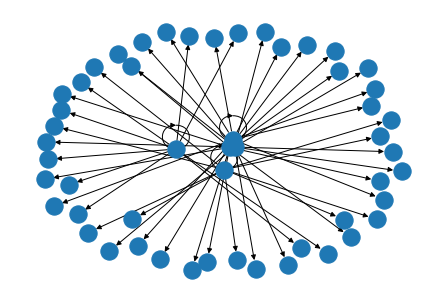

In [ ]:
nx.draw(CG)

In [ ]:
CG.nodes

NodeView((1973.0, 25708.0, 29756.0, 47422.0, 26068.0, 35845.0, 4604.0, 33828.0, 42536.0, 48484.0, 36496.0, 35892.0, 45281.0, 4858.0, 31310.0, 31713.0, 35785.0, 34782.0, 31389.0, 30499.0, 36346.0, 42487.0, 39816.0, 35198.0, 46339.0, 44021.0, 44410.0, 46267.0, 39531.0, 7318.0, 17901.0, 12516.0, 6547.0, 1429.0, 39632.0, 31497.0, 8760.0, 436.0, 12407.0, 18010.0, 267, 30505.0, 41383.0, 33471.0, 36671.0, 23274.0, 43165.0, 16594.0, 23096.0, 36436.0, 46360.0, 1584))

NetworkXError: ignored

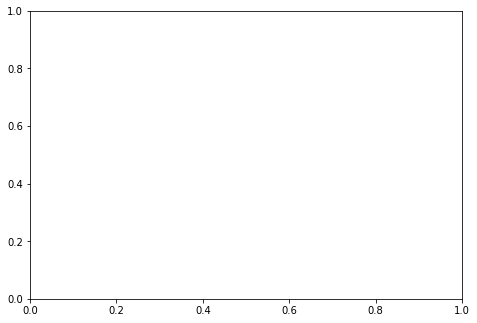

In [ ]:
# pos = nx.spring_layout(CG) 
# labels =nx.get_edge_attributes(CG,'weight')
# nx.draw_networkx_edge_labels(CG, pos, edge_labels = labels) 
nx.draw(CG, pos,with_labels = True, font_weight = "bold") 

In [ ]:

"""
input : sentence
output : a number
"""
# word = ''
# alpha = 0.1 # context 2단계로 넘어갈 때
# first_C_words = pmi.context_words(word,10)
# second_C_words = [alpha * first_word for word in first_C_words

In [ ]:
pmi.context_words('자살',10)

[('도피', 6.844622458591964),
 ('삵', 6.031369397834147),
 ('살고싶은데', 5.772712722570554),
 ('뽁뽁', 5.685233690813876),
 ('했데', 5.524714801301454),
 ('좆피', 5.288600593862374),
 ('자살', 5.274353861018971),
 ('머애', 5.262282104003921),
 ('은부', 5.249461278984446),
 ('대왕고래', 5.23685594024716)]

In [ ]:
pmi.similar_words('자살')

[('도피', 0.1711917538845089),
 ('살자', 0.10171809134334331),
 ('고독사', 0.10088364343665246),
 ('ㅈㅏ', 0.09487142734684706),
 ('시도', 0.09244949903860067),
 ('자퇴', 0.09209061439356447),
 ('하지말라고', 0.08980970238880681),
 ('언급', 0.0893938727791479),
 ('섹스', 0.08623966165311425),
 ('입원', 0.08578130573074016)]

In [ ]:
"""
PMI 그래프 가져와서.
sentence -> tokenizer -> graph 에 넣음 -> 각 키워드 
키워드 별 연관 지수(graph에서 몇단계 + 몇등) 다 더하기 -> 단순하게 -> 만드는 게 중요 진짜로.
threshold 만 정해서 yes or no.
"""
def 
depressed_rate = ""

### 게시물들은 __언제__, 얼마나 작성되었을까?

In [ ]:
# 분석에 앞서, 멀티 인덱스 DF 생성

df = data.set_index('id').copy()
df = df.set_index(['date','author'])
group_by_title_sum = df.groupby(level=['date', 'author']).sum()
group_by_count = df.groupby(level=['date', 'author']).count()
group_by_title_sum

title  \
date       author                                                             
2021-03-03 ..(106.101)    아직 어려서 그런지 .외향 적성격 은 변하 지 않는다쩜쩜 는아 시발님 솔직히한 달 ...   
           ..(117.111)                                                 아시 발   
           ..(182.213)    ㅠㅡㅠ외로 와븅신 가 틈오늘 테 스 스커트 입었 어주 1회 외출 제한 ,집중 이 넘...   
           176(92.38)                                          나 몸팔 아 본적 있음   
           234235         울 갤 왜 폐쇄 됐냐 ㅡㅡ 형 뒤짐형 여 갤러 가 결혼 해 즈 면 존나 잘 해 줄거...   
...                                                                     ...   
2022-10-27 햄이브            즐거운 수학여행나 연애 할 사람버스 노래 틀 떼창 하면서 간다아 미친 제육 볶음 개...   
           헤으응만두(211.36)                            간만 입니다 . 조만간 식 올릴것 같습니다   
           헬더구            술 먹든 호캉스 를 하든 게임 하든 멀하든 재미 가 없다피방 옆 커플 들 싸우고 잇...   
           히코.            하루 한번 워뇽 직캠 봄여자 는 필라테스 의무 교육 시켜 야함워뇽 다리 길이 체감 ...   
           힌개미            구스구스덕 하실 분할거 없으 신분 들어와 보삼나 구 구덕 할 친구 없구나 ...구 ...   

                                                                       link  
date       author                                                            
2021-03-03 ..(106.101)    https://m.dcinside.com/board/depression_new1/4...  
           ..(117.111)    https://m.dcinside.com/board/depression_new1/9...  
           ..(182.213)    https://m.dcinside.com/board/depression_new1/3...  
           176(92.38)     https://m.dcinside.com/board/depression_new1/3...  
           234235         https://m.dcinside.com/board/depression_new1/8...  
...                                                                     ...  
2022-10-27 햄이브            https://m.dcinside.com/board/depression_new1/4...  
           헤으응만두(211.36)  https://m.dcinside.com/board/depression_new1/4...  
           헬더구            https://m.dcinside.com/board/depression_new1/4...  
           히코.            https://m.dcinside.com/board/depression_new1/4...  
           힌개미            https://m.dcinside.com/board/depression_new1/4...  

[218921 rows x 2 columns]

In [ ]:
group_by_count

title  link
date       author                    
2021-03-03 ..(106.101)       30    30
           ..(117.111)        1     1
           ..(182.213)        7     7
           176(92.38)         1     1
           234235            54    54
...                         ...   ...
2022-10-27 햄이브               12    12
           헤으응만두(211.36)      1     1
           헬더구               16    16
           히코.               22    22
           힌개미               12    12

[218921 rows x 2 columns]

In [ ]:
# 달, 요일 별로 게시물 분포 보기

# 1. data.date.dt.month
# 2. data.date.dt.day_names()

df = data.copy()
df.date = data.date.dt.month
# df = df.loc[:,['id','date','author']].groupby(by='date').groupby(by='author').count()
# grouped_by_date_count = df.sort_values(by='date')
# grouped_by_date_count

ValueError: ignored

### 게시물들은 __누가__, 얼마나 작성했을까?

In [ ]:
df = data.set_index('id').copy()
df = df.set_index(['date','author'])
group_by = df.groupby(level=['date', 'author']).count()
group_by

In [ ]:
grouped_by_author_count

,id
author,
젠지우승(121.131),1
일침남(106.101),1
일이삼(121.139),1
일엉(118.235),1
김창수(211.215),1
...,...
김경직,32212
루시드,36911
제이통,43441


In [ ]:

temp

,author,title,id
0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5
1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49
2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1
3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17
4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4
...,...,...,...
32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1
32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186
32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16
32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3


In [ ]:
grouped_by_author = pd.read_csv(save_dir+'/'+'contents_by_author.csv')
# temp = pd.merge(left = temp , right = data.loc[:,['id','author']].groupby(by='author').count(), how = "inner", on = "author")
# temp.rename(columns = {'id':'post_count'},inplace=True)
# grouped_by_author['whole_length'] = grouped_by_author.title.str.len()
grouped_by_author


,Unnamed: 0,author,title,post_count,whole_length
0,0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112
1,1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477
2,2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14
3,3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227
4,4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38
...,...,...,...,...,...
32945,32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22
32946,32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331
32947,32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208
32948,32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24


In [ ]:
from tqdm import tqdm
tqdm.pandas()
grouped_by_author['diversity'] = grouped_by_author.title.progress_apply(lambda x : len(set(tokenizer(x))) / len(tokenizer(x)))

100%|██████████| 32950/32950 [01:50<00:00, 297.94it/s]


In [ ]:
grouped_by_author

,Unnamed: 0,author,title,post_count,whole_length,diversity
0,0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112,0.970588
1,1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477,0.946565
2,2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14,1.000000
3,3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227,0.986301
4,4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38,1.000000
...,...,...,...,...,...,...
32945,32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22,1.000000
32946,32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331,0.773676
32947,32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208,0.935484
32948,32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24,1.000000


In [ ]:
## title -> tokenized 된 걸로 바꾸고 -> 우울증 지수 계산 


,author,title,post_count,whole_length
0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112
1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477
2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14
3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227
4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38
...,...,...,...,...
32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22
32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331
32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208
32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24


In [ ]:

grouped_by_author.to_csv(save_dir+'/'+'contents_by_author.csv')

In [ ]:
from soynlp.vectorizer import sent_to_word_contexts_matrix
from scipy import sparse
import pickle
from soynlp.word import pmi as pmi_func

okt = Okt() ## 미리 분석한 정보 로드
mat_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/words_sparse_mat.npz"
index_list_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/idx_to_vocabs"

x = sparse.load_npz(mat_save_path)
with open(index_list_save_path, "rb") as fp:   # Unpickling
  idx2vocab = pickle.load(fp)

pmi, px, py = pmi_func(
    x,
    min_pmi = 0,
    alpha = 0.0,
    beta = 0.75
)

vocab2idx = {vocab:idx for idx, vocab in enumerate(idx2vocab)}
query = vocab2idx['살고싶다']

submatrix = pmi[query,:].tocsr() # get the row of query
contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
pmi_i = submatrix.data

most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:10]
most_relateds = [(idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

from pprint import pprint
pprint(most_relateds)

[('말안하고', 5.539395551806139),
 ('받으며', 5.453687463545265),
 ('베어그릴스', 5.371115126218525),
 ('박영', 5.2524471223073546),
 ('키우면서', 5.2524471223073546),
 ('배당금', 5.19948394689689),
 ('성공해서', 5.182629305007846),
 ('대강', 5.140154545808996),
 ('가혹하', 5.134225414154668),
 ('하쿠', 5.118760948752615)]


In [ ]:
##SoyNLP 훈련 및 저장 코드
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(data[data.title.isna()==False].title)
word_score_table = word_extractor.extract()

model_fname="/content/drive/MyDrive/Detect_SC_symptoms/models" + "/" + "soy_wordExtractor_full.model"
word_extractor.save(model_fname)

training was done. used memory 6.691 Gb
all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


In [ ]:
import math
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

## Word_Extractor param 설정 및 로드
word_extractor = WordExtractor(min_frequency=10,
                               min_cohesion_forward=5.0,
                               min_right_branching_entropy=0.0)
word_extractor.load(model_fname)

## Cohesion 과 Entropy 계산해서 tokenizer 생성
scores = word_extractor.word_scores()
scores = {key : (scores[key].cohesion_forward * math.exp(scores[key].right_branching_entropy)) \
          for key in scores.keys()}

## tokenizer 생성
tokenizer = LTokenizer(scores=scores)

all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


In [ ]:
## SoyNLP 사용 예 -> SoyNLP(tokenizer) -> okt pos tagger -> 불용어 제거
from konlpy.tag import Okt
from soynlp.normalizer import *

def preprocess_tokenizer(sentence) : 

  pos_tagger = Okt()
  # sentence = emoticon_normalize(sentence)
  # sentence = repeat_normalize(sentence)

  #soynlp tokenizer로 나눠준 후 konlpy Okt postagger로 품사 판별
  return [word[0]
          for word in pos_tagger.pos(' '.join(tokenizer.tokenize(sentence)))
          if word[1] != 'Josa'] # 조사는 분석에서 제외


# preprocess(tokenizer, sent)
for sent in data.title[-5:] :
  print('before :', sent)
  # print('after :', okt.morphs(sent))
  print(preprocess_tokenizer(sent))

before : 나 병신인가...
['나', '병신', '...']
before : 나고닉으로글올리규싶읃데
['나고', '닉', '글', '올리', '규', '싶', '읃데']
before : 씨발 남자직원이 음식 깔아주니까 
['씨발', '남자', '직원', '음식', '깔아', '주']
before : 나도근데아이디두번바꿈
['나도', '근데', '아이디', '두', '번', '바꿈']
before : 알바 바보 쉨ㅋㅋㅋ 나도 차단해봐라
['알바', '바보', '쉨', 'ㅋㅋㅋ', '나도', '차단', '해봐라']


## PMI 분석


단어들 간의 연관관계를 분석해서 자살 관련 정보 파악에 도움이 되는 __다른 단어__들은 무엇이 있는 지 알아보자.

참고 : [SoyNLP 공식 문서](!https://github.com/lovit/soynlp#vectorizer)

In [ ]:
from soynlp.vectorizer import sent_to_word_contexts_matrix

x, idx2vocab = sent_to_word_contexts_matrix(
    data.title,
    windows=3,
    min_tf=10,
    tokenizer=preprocess_tokenizer, # (default) lambda x:x.split(),
    dynamic_weight=False,
    verbose=True
)

from soynlp.word import pmi

pmi_dok = pmi(
    x,
    min_pmi=0,
    alpha=0.0001,
    verbose=True
)

Create (word, contexts) matrix
  - counting word frequency from 1175000 sents, mem=5.404 Gb

AttributeError: ignored

# 방금 만든 거 무조건 저장해야함.....! 2시간 걸림

In [ ]:
vocab2idx = {vocab:idx for idx, vocab in enumerate(idx2vocab)}
query = vocab2idx['아이오아이']

submatrix = pmi[query,:].tocsr() # get the row of query
contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
pmi_i = submatrix.data

most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:10]
most_relateds = [(idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

from pprint import pprint
pprint(most_relateds)

In [ ]:
from soynlp.utils import most_similar

most_similar('아이오아이', pmi, vocab2idx, idx2vocab)

'ㅋㅋ쿠ㅜㅜ'

In [ ]:
from soynlp.postagger import Dictionary
from soynlp.postagger import LRTemplateMatcher
from soynlp.postagger import LREvaluator
from soynlp.postagger import SimpleTagger
from soynlp.postagger import UnknowLRPostprocessor

dictionary = Dictionary(pos_dict)
generator = LRTemplateMatcher(dictionary)    
evaluator = LREvaluator()
postprocessor = UnknowLRPostprocessor()
tagger = SimpleTagger(generator, evaluator, postprocessor)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ds',
 '_scores',
 'tokenize']

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df, x="total_bill")
fig.show()